In [1]:
# Step 1: Load the Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your dataset (replace the path with your actual file)
data = pd.read_csv('crypto_data.csv', parse_dates=['Timestamp'], index_col='Timestamp')

# Check the first few rows of the data
data.head()

# Step 2: Calculate Log Changes (Log-Returns) for Forecasting
data['Log_Close'] = np.log(data['Close'])

# Calculate the log change (percentage change in the log price)
data['Log_Change'] = data['Log_Close'].diff()  # This will be the target variable

# Drop NaN values that may appear due to the diff() operation
data = data.dropna()

In [2]:
# Step 3: Convert Log Change to 4 Classes (Little Up, Big Up, Little Down, Big Down)
def classify_change(log_change):
    if log_change > 0.002:  # > 0.2% increase
        return 3  # Big Up
    elif log_change > 0:  # 0 to 0.2% increase
        return 2  # Little Up
    elif log_change < -0.002:  # < -0.2% decrease
        return 1  # Big Down
    else:  # 0 to -0.2% decrease
        return 0  # Little Down

# Apply the classification function
data['Class'] = data['Log_Change'].apply(classify_change)

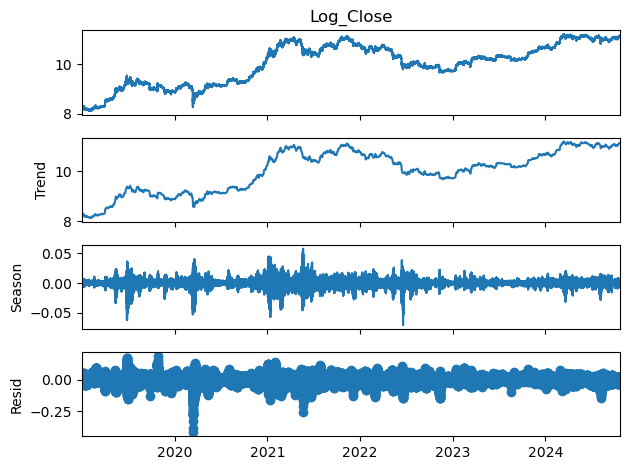

In [3]:
from statsmodels.tsa.seasonal import STL

# Step 3: STL Decomposition
seasonal_period = 96  # 15-minute intervals per day (96 intervals in 24 hours)
stl = STL(data['Log_Close'], period=seasonal_period, robust=True)
result = stl.fit()

# Get the decomposed components
data['STL_Trend'] = result.trend
data['STL_Seasonal'] = result.seasonal
data['STL_Residual'] = result.resid

# Plot the decomposed components
result.plot()
plt.show()

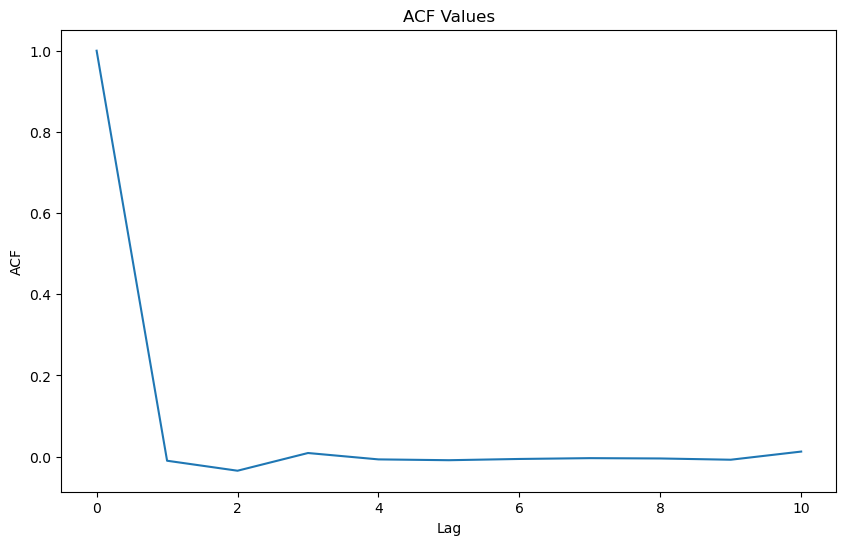

In [4]:
from statsmodels.tsa.stattools import acf

# Step 4: Calculate ACF Features
# Calculate ACF for different lags (you can adjust the number of lags as needed)
lags = 10  # Number of lags to consider for autocorrelations
acf_values = acf(data['Log_Change'], nlags=lags)

# The first autocorrelation
data['ACF_1'] = acf_values[1]  # ACF at lag 1

# Sum of squares of the first 10 autocorrelations
data['ACF_sum_sq'] = np.sum(acf_values[1:]**2)

# If you want more detailed ACF features, you can add higher-order lags as columns
for i in range(1, lags+1):
    data[f'ACF_{i}'] = acf_values[i]

# Plot ACF values for visual check
plt.figure(figsize=(10, 6))
plt.plot(range(lags+1), acf_values)
plt.title("ACF Values")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.show()

In [5]:
# Step 5: Prepare Features and Target for LightGBM
# We will use the following features:
# - Log_Close (original log price)
# - STL_Trend (trend component)
# - STL_Seasonal (seasonal component)
# - STL_Residual (residual component)
# - ACF_1 (first autocorrelation)
# - ACF_sum_sq (sum of squares of first 10 autocorrelations)

# Prepare the feature matrix (X) and target variable (y)
X = data[['Volume', 'Open', 'Close', 'High', 'Low', 'STL_Trend', 'STL_Seasonal', 'STL_Residual', 'ACF_1', 'ACF_sum_sq']]
y = data['Log_Change']  # Target is the log change for the next day

# Optional: You can add other lag features here if needed

In [6]:
# Step 7: Train LightGBM Classifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Create a LightGBM Dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set LightGBM parameters for multiclass classification
params = {
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class': 4,  # 4 classes
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the model
lgb_model = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=1000)

# Predict on test data
y_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

# Convert predictions to class labels
y_pred_class = np.argmax(y_pred, axis=1)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 162599, number of used features: 8
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more le

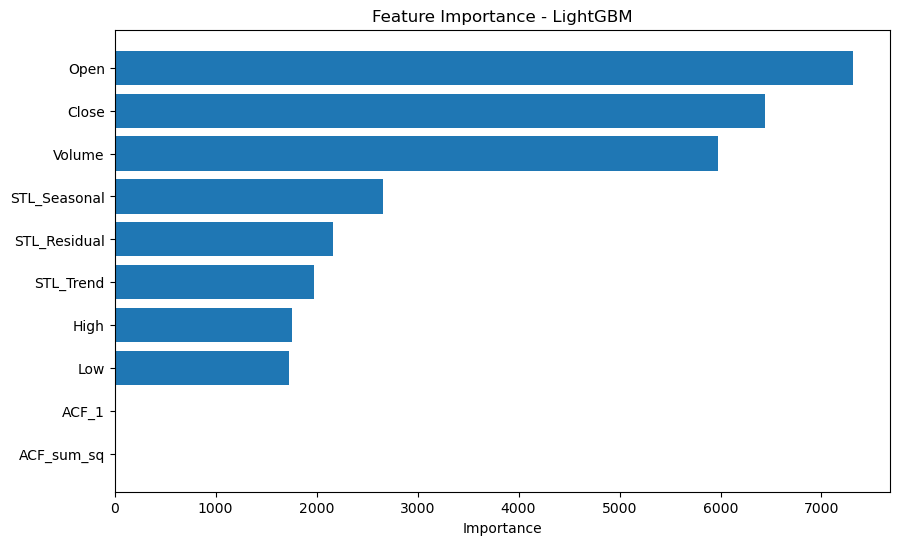

In [18]:
import matplotlib.pyplot as plt

# Plot feature importance using Matplotlib
importance = lgb_model.feature_importance(importance_type='split')
features = X.columns

# Sort features by importance
sorted_idx = importance.argsort()

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), features[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature Importance - LightGBM')
plt.show()


In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report

# Step 10: Evaluation Metrics

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_class)

# Accuracy
accuracy = accuracy_score(y_test, y_pred_class)

# F1 Score (Weighted Average for all classes)
f1 = f1_score(y_test, y_pred_class, average='weighted')

# Classification Report (Precision, Recall, F1-score for each class)
class_report = classification_report(y_test, y_pred_class, target_names=['Little Down', 'Big Down', 'Little Up', 'Big Up'])

# Plot Confusion Matrix using Matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = ['Little Down', 'Big Down', 'Little Up', 'Big Up']
tick_marks = np.arange(len(classes))

plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

plt.ylabel('True label')
plt.xlabel('Predicted label')

# Annotate the confusion matrix with values
thresh = cm.max() / 2
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# Print Evaluation Metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Weighted F1 Score: {f1:.4f}')
print('Classification Report:\n', class_report)


ValueError: Classification metrics can't handle a mix of continuous and binary targets